# Synthetic Data Generation Baseline

In [35]:
import os, sys
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
import pickle
import sklearn
import tqdm.notebook as tqdm

from sklearn.model_selection import train_test_split
sns.set_theme()
sys.path.append(os.path.abspath('..'))

torch.backends.cudnn.benchmark = True

In [36]:
%load_ext autoreload
%autoreload 2

from lib.vae_models import CVAE
import lib.datasets as datasets
import lib.utils as utils
from lib.lda_lib import EntityEncoder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import Data

In [37]:
DATASET_NAME = 'goi4_dp_full_Gipuzkoa'
RANDOM_SEED = 2112
np.random.seed(RANDOM_SEED)

In [38]:
df = pd.read_csv(f'../data/{DATASET_NAME}/dataset.csv')
data, dates, users = df.iloc[:,:-2].values, df.date.values, df.user.values
date_ids, user_ids = df.date.unique(), df.user.unique()
num_days, num_users = len(date_ids), len(user_ids)
print(f'Loaded {len(data)} consumption profiles from {num_days} dates and {num_users} users')

Loaded 2522880 consumption profiles from 365 dates and 6912 users


In [39]:
date_dict = np.load(f'../data/{DATASET_NAME}/encode_dict.npy', allow_pickle=True).item()["date_dict"]
date_dict_inv = {v: k for k, v in date_dict.items()}

In [40]:
if not os.path.exists(f'../data/{DATASET_NAME}/raw_dates.npy'):
    raw_dates = np.array([datetime.datetime.strptime(date_dict_inv[d], '%Y-%m-%d') for d in dates])
    np.save(f'../data/{DATASET_NAME}/raw_dates.npy', raw_dates)
else:
    raw_dates = np.load(f'../data/{DATASET_NAME}/raw_dates.npy', allow_pickle=True)

In [41]:
metadata = pd.read_csv(f'../data/{DATASET_NAME}/metadata.csv')

In [42]:
unique_provinces = metadata.province.unique()
print(f'Loaded metadata for {len(unique_provinces)} provinces')
print(f"Uniqe provinces are: {unique_provinces}")

Loaded metadata for 1 provinces
Uniqe provinces are: ['Gipuzkoa']


### Prepare Conditions

In [43]:
months = np.array([d.month for d in raw_dates])
weekdays = np.array([d.weekday() for d in raw_dates])
is_weekend = np.array([int(d.weekday() >= 5) for d in raw_dates])

In [44]:
df_temp = pd.read_csv(f'../data/{DATASET_NAME}/spain_temp_daily.csv')
df_temp.index = pd.to_datetime(df_temp['date'])
df_temp.drop(columns='date', inplace=True)
df_temp = df_temp.loc[raw_dates]

In [45]:
df_prec = pd.read_csv(f'../data/{DATASET_NAME}/spain_prec_daily.csv')
df_prec.index = pd.to_datetime(df_prec['date'])
df_prec.drop(columns='date', inplace=True)
df_prec = df_prec.loc[raw_dates]
df_prec = df_prec.sort_values(by='prec_total')

In [46]:
condition_kwargs = {}

In [47]:
ADD_MONTHS = True
ADD_WEEKDAYS = True
ADD_IS_WEEKEND = False
ADD_TEMPERATURE_MIN = False
ADD_TEMPERATURE_MAXDELTA = False
ADD_PRECIPITATION_LEVEL = False
ADD_USERS = True

condition_kwargs["tags"], condition_kwargs["types"], condition_kwargs["supports"], condition_set  = [], [], [], {}
if ADD_MONTHS: 
    condition_kwargs["tags"].append("months")
    condition_kwargs["types"].append("circ")
    condition_kwargs["supports"].append(np.unique(months).tolist())
    condition_set["months"] = months[...,None]
if ADD_WEEKDAYS: 
    condition_kwargs["tags"].append("weekdays")
    condition_kwargs["types"].append("circ")
    condition_kwargs["supports"].append(np.unique(weekdays).tolist())
    condition_set["weekdays"] = weekdays[...,None]
if ADD_IS_WEEKEND:
    condition_kwargs["tags"].append("is_weekend")
    condition_kwargs["types"].append("cat")
    condition_kwargs["supports"].append([0, 1])
    condition_set["is_weekend"] = is_weekend[...,None]
if ADD_TEMPERATURE_MIN:
    condition_kwargs["tags"].append("temp_min")
    condition_kwargs["types"].append("cont")
    condition_kwargs["supports"].append([df_temp[condition_kwargs["tags"][-1]].min(), df_temp[condition_kwargs["tags"][-1]].max()])
    condition_set["temp_min"] = df_temp[condition_kwargs["tags"][-1]].values[...,None]
if ADD_TEMPERATURE_MAXDELTA:
    condition_kwargs["tags"].append("temp_max_delta")
    condition_kwargs["types"].append("cont")
    condition_kwargs["supports"].append([df_temp[condition_kwargs["tags"][-1]].min(), df_temp[condition_kwargs["tags"][-1]].max()])
    condition_set["temp_max_delta"] = df_temp[condition_kwargs["tags"][-1]].values[...,None]
if ADD_PRECIPITATION_LEVEL:
    condition_kwargs["tags"].append("precipitation_level")
    condition_kwargs["types"].append("ord")
    condition_kwargs["supports"].append(np.unique(df_prec["label"]).tolist())
    condition_set["precipitation_level"] = df_prec["label"].values[...,None]


In [48]:
conditioner = datasets.Conditioner(**condition_kwargs, condition_set=condition_set)

#### Set Resolution

In [49]:
RESOLUTION = 1 #in hours
PAD = 0

if RESOLUTION == 12:
    X = np.reshape(data, (-1, 24))
    X = np.reshape(np.concatenate([X[:,6:], X[:,:6]], axis=-1), (num_users, num_days, int(24/RESOLUTION), int(RESOLUTION))).sum(axis=-1)    #circle shift the last dimension of X
else:
    X = np.reshape(data, (num_users, num_days, int(24/RESOLUTION), int(RESOLUTION))).sum(axis=-1)
    if PAD != 0: X = np.concatenate((X[:,:-(PAD//24+2),-PAD:], X[:,(PAD//24+1):-(PAD//24+1),:], X[:,(PAD//24+2):,:PAD]), axis=-1)

condition_set = {k: np.reshape(v, (num_users, num_days, -1)) for k, v in condition_set.items()}
if PAD != 0: condition_set = {k: v[:,1:-1,:] for k, v in condition_set.items()}

num_days = X.shape[1]

#### Clean Data

In [50]:
nonzero_user_mask = np.sum(np.all(X == 0, axis=2), axis=1) < num_days
print(f'Removing {(~nonzero_user_mask).sum()} users with all-zero consumption profiles')
positive_user_mask = np.sum(np.any(X < 0, axis=2), axis=1) == 0
print(f'Removing {(~positive_user_mask).sum()} users with any-negative consumption profiles')
user_mask = nonzero_user_mask & positive_user_mask
X = X[user_mask]
condition_set = {k: v[user_mask] for k, v in condition_set.items()}

Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles


#### Ampute the Dataset

In [51]:
np.random.seed(RANDOM_SEED)
n, a, b = num_days, 0.85, 10.0
missing_days = np.random.binomial(n, p=np.random.beta(a, b, size=X.shape[0]), size=X.shape[0])
print(f"Mean of missing days: {n*a/(a+b):.2f}")

Mean of missing days: 28.59


In [52]:
X_missing = X.copy().astype(float)
condition_missing = {k: v.copy().astype(float) for k, v in condition_set.items()}

for user in range(X.shape[0]): 
    X_missing[user, :missing_days[user]] = np.nan
    for k in condition_missing.keys():
        condition_missing[k][user, :missing_days[user]] = np.nan

#### Subsample the Dataset

In [53]:
USER_SUBSAMPLE_RATE, DAY_SUBSAMPLE_RATE = 1, 1
X, X_missing = X[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :], X_missing[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :]
condition_set = {k: v[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :] for k, v in condition_set.items()}
condition_missing = {k: v[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :] for k, v in condition_missing.items()}
num_users, num_days, num_features = X.shape
X_gt_list = [X[user, :missing_days[user]]*1 for user in range(num_users)]
X_gt_condition_list = {k: [v[user, :missing_days[user]]*1 for user in range(num_users)] for k, v in condition_set.items()}

print("{:.<40}{:.>5}".format("Number of (subsampled/filtered) users", num_users))
print("{:.<40}{:.>5}".format("Number of (subsampled) days", num_days))
print("{:.<40}{:.>5}".format("Number of (aggregated) features", num_features))

Number of (subsampled/filtered) users....6830
Number of (subsampled) days...............365
Number of (aggregated) features............24


In [54]:
missing_idx_mat  = np.isnan(X_missing).any(2)
missing_num_labels = {"user": missing_idx_mat.sum(1), "day": missing_idx_mat.sum(0) }

In [55]:
X_missing = X_missing.reshape(-1, num_features)
user_ids = np.arange(num_users).repeat(num_days)
conditions_missing = {k: v.reshape(-1, v.shape[-1]) for k, v in condition_missing.items()}
missing_idx = np.isnan(X_missing.sum(1))

#### Prepare the Training Data with Missing Records

In [56]:
SHIFT = 1.0
ZERO_ID = -3
LOG_SPACE = True
nonzero_mean, nonzero_std = utils.zero_preserved_log_stats(X_missing)
X_missing = utils.zero_preserved_log_normalize(X_missing, nonzero_mean, nonzero_std, log_output=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)

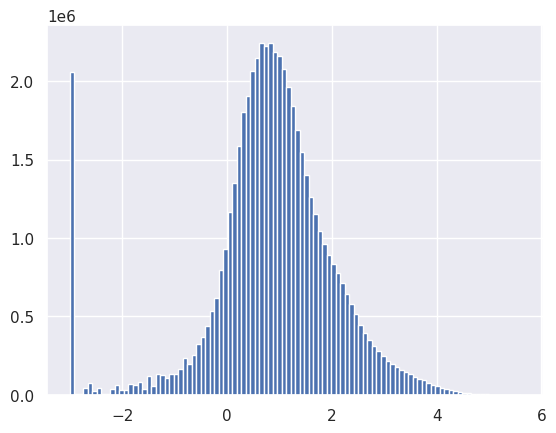

In [57]:
plt.hist(X_missing.flatten(), bins=100)
plt.show()

## User Encodings

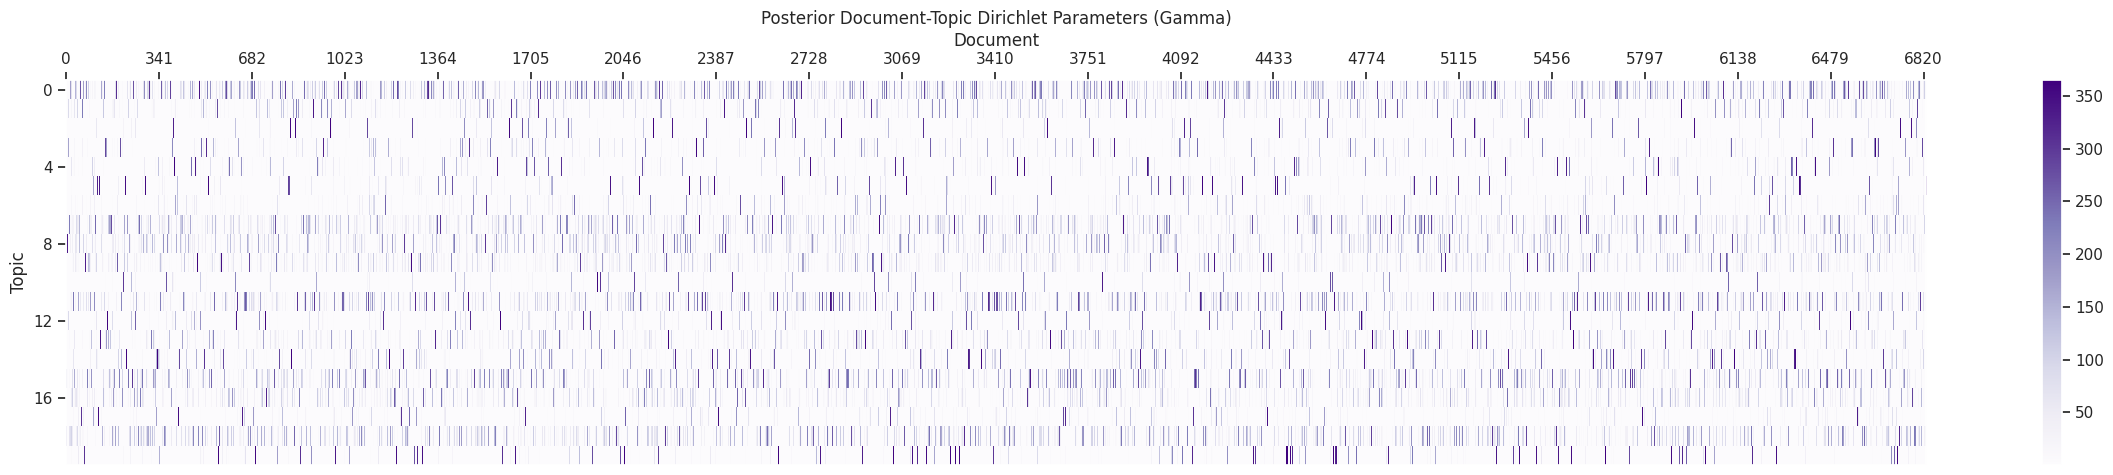

In [58]:
if ADD_USERS:
    NUM_TOPICS = 20
    VOCAB_SIZE = 1000
    ALPHA = 1.0/NUM_TOPICS

    model_kwargs = {"num_topics": NUM_TOPICS,
                    "reduce_dim": False,
                    "num_lower_dims": None,
                    "num_clusters": VOCAB_SIZE,
                    "random_state": RANDOM_SEED,
                    "_": {"user_subsample_rate": USER_SUBSAMPLE_RATE},}
    fit_kwargs = {"lda": {'doc_topic_prior': ALPHA,  ## alpha
                        'topic_word_prior': 1.0/VOCAB_SIZE, ## eta
                        'perp_tol': 5e-2, 
                        'max_iter': 10, ## number of epochs
                        'batch_size': 64, 
                        'verbose': True, 
                        'learning_method': 'online', 
                        'evaluate_every': 10,
                        'n_jobs': -1},}
    
    base_dir = f'../data/{DATASET_NAME}/user_encoding_models'
    model_dir = utils.find_matching_model(base_dir, model_kwargs, fit_kwargs)

    if model_dir is not None:
        entity_model = EntityEncoder.load(model_dir)
        user_gamma = np.load(f'{model_dir}/user_gamma.npy')
    else:
        entity_model = EntityEncoder(**model_kwargs)
        entity_model.fit(X_missing.reshape(num_users, num_days, -1), fit_kwargs)
        user_gamma = entity_model.transform(X_missing.reshape(num_users, num_days, -1))

        model_dir = os.path.join(base_dir, f'model_{len(os.listdir(base_dir)) + 1}')
        os.makedirs(model_dir, exist_ok=True)
        entity_model.save(model_dir)
        np.save(f'{model_dir}/user_gamma.npy', user_gamma)
    
    fig, ax = plt.subplots(figsize=(30,5))
    im = ax.imshow(user_gamma.T, aspect='auto', cmap='Purples', interpolation='nearest')
    ax.set_title('Posterior Document-Topic Dirichlet Parameters (Gamma)')
    ax.set_ylabel('Topic')
    ax.set_xlabel('Document')
    ax.set_yticks(np.arange(NUM_TOPICS))
    ax.set_xticks(np.arange(num_users))
    ax.xaxis.tick_top()
    ax.yaxis.tick_left()
    ax.xaxis.set_label_position('top')
    ax.grid(False)
    plt.yticks(np.arange(0, NUM_TOPICS, NUM_TOPICS//5))
    plt.xticks(np.arange(0, num_users, num_users//20))
    fig.colorbar(im, ax=ax)
    plt.show()

    if not os.path.exists(f'{model_dir}/user_gamma.pdf'): fig.savefig(f'{model_dir}/user_gamma.pdf', format='pdf', bbox_inches='tight', transparent=True)
    


### Turn embeddings into conditions

In [59]:
conditioner.add_condition(tag="users", typ="dir", support=[ALPHA, entity_model.doc_lengths.max()], data=user_gamma)
conditions_missing["users"] = user_gamma.repeat(num_days, axis=0)

## Ctd

In [60]:
X_missing = X_missing[~missing_idx]
user_ids_missing = user_ids[~missing_idx]
conditions_missing = {k: v[~missing_idx] for k, v in conditions_missing.items()}

X_gt_condition_list["users"] = [np.array([user_gamma[user_id]]*num_missing_days) for user_id, num_missing_days in enumerate(missing_days)]

In [61]:
## split the X_missing and conditions_missing into training and validation sets
VAL_RATIO = 0.1
random_idx = np.random.permutation(len(X_missing))
val_idx = random_idx[:int(len(X_missing)*VAL_RATIO)]
train_idx = random_idx[int(len(X_missing)*VAL_RATIO):]

X_train, X_val = X_missing[train_idx], X_missing[val_idx]
user_ids_train, user_ids_val = user_ids_missing[train_idx], user_ids_missing[val_idx]
conditions_train = {k: v[train_idx] for k, v in conditions_missing.items()}
conditions_val = {k: v[val_idx] for k, v in conditions_missing.items()}

In [62]:
trainset = datasets.ConditionedDataset(inputs=X_train, conditions=conditions_train, conditioner=conditioner)
valset = datasets.ConditionedDataset(inputs=X_val, conditions=conditions_val, conditioner=conditioner)
print(f"Number of Training Points: {len(trainset)}")
print(f"Number of Validation Points: {len(valset)}")

Number of Training Points: 2065749
Number of Validation Points: 229527


### Model

In [96]:
distribution_dict = {"posterior": {"dist_type": "normal",
                                    "learn_sigma": True,
                                    "sigma_lim": 0.05,
                                    "total_max_std": 3.0, 
                                    "mu_upper_lim": 5.0, 
                                    "mu_lower_lim": -5.0,
                                    "num_neurons": 1250,
                                    "num_hidden_layers": 2,
                                    "dropout": True,
                                    "dropout_rate": 0.20,
                                    "batch_normalization": True,
                                    "resnet": True},
                    "likelihood": {"dist_type": "dict-gauss",
                                    "vocab_size": 100,
                                    "learn_sigma": True,
                                    "sigma_lim": 1e-4,
                                    "marginal_var_lim": 0.05,
                                    "total_max_std": 3.0, 
                                    "mu_upper_lim": 5.0, 
                                    "mu_lower_lim": ZERO_ID,
                                    "num_neurons": 1250,
                                    "num_hidden_layers": 2,
                                    "dropout": True,
                                    "dropout_rate": 0.20,
                                    "batch_normalization": True,
                                    "resnet": True}
                    }

In [97]:
model_kwargs = {"latent_dim": 24,
                "condencoding_dim": None,
                "distribution_dict": distribution_dict,
                }

In [98]:
model = CVAE(input_dim=num_features, conditioner=conditioner, **model_kwargs)
print("Number of encoder parameters:", model.encoder._num_parameters())
print("Number of decoder parameters:", model.decoder._num_parameters())

Number of encoder parameters: 7955048
Number of decoder parameters: 8050124


### Training

In [99]:
train_kwargs = {
                "lr": 1e-3,
                "beta": 1.0,
                "num_mc_samples": 16,
                "validation_mc_samples": 16,
                "weight_decay": 1e-5,
                "gradient_clipping": True,
                "gradient_clipping_kwargs": {"max_norm":10.0},
                "lr_scheduling": True,
                "lr_scheduling_kwargs": {"threshold":1e-1, "factor":1/2, "patience":3, "min_lr":5e-5},
                "earlystopping": True,
                "earlystopping_kwargs": {"patience":6, "delta":1e-1},
                "epochs": 1000,
                "verbose_freq": 250,
                "tensorboard": True,
                "batch_size": 1024,
                "validation_freq": 2000,
                "device": "cuda:1",
                "tqdm_func": tqdm.tqdm,
                }

In [100]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_kwargs["batch_size"], shuffle=True, drop_last=True, num_workers=1, pin_memory=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=train_kwargs["batch_size"]*16, shuffle=False, drop_last=False, num_workers=1, pin_memory=True)

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_kwargs["batch_size"], shuffle=True, drop_last=True)
# valloader = torch.utils.data.DataLoader(valset, batch_size=train_kwargs["batch_size"]*8, shuffle=False, drop_last=False)

In [101]:
torch.cuda.empty_cache()
model.fit(trainloader=trainloader, valloader=valloader, **train_kwargs)

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iteration in Epoch:   0%|          | 0/2017 [00:00<?, ?it/s]

Iteration: 250 -- ELBO=-1.8130e+01 / RLL=-1.3529e+01 / KL=4.6009e+00
Iteration: 500 -- ELBO=-1.4486e+01 / RLL=-1.1663e+01 / KL=2.8229e+00
Iteration: 750 -- ELBO=-1.4239e+01 / RLL=-1.1454e+01 / KL=2.7847e+00
Iteration: 1000 -- ELBO=-1.3015e+01 / RLL=-1.0758e+01 / KL=2.2567e+00
Iteration: 1250 -- ELBO=-1.2153e+01 / RLL=-9.8744e+00 / KL=2.2784e+00
Iteration: 1500 -- ELBO=-1.3524e+01 / RLL=-1.1276e+01 / KL=2.2477e+00
Iteration: 1750 -- ELBO=-1.2384e+01 / RLL=-1.0075e+01 / KL=2.3097e+00
Validation -- ELBO=-1.1631e+01 / RLL=-9.1904e+00 / KL=2.4406e+00
Iteration: 2000 -- ELBO=-1.1704e+01 / RLL=-9.2629e+00 / KL=2.4412e+00
Iteration: 2250 -- ELBO=-1.2337e+01 / RLL=-1.0026e+01 / KL=2.3107e+00
Iteration: 2500 -- ELBO=-1.2107e+01 / RLL=-9.6644e+00 / KL=2.4426e+00
Iteration: 2750 -- ELBO=-1.2500e+01 / RLL=-1.0080e+01 / KL=2.4200e+00
Iteration: 3000 -- ELBO=-1.1795e+01 / RLL=-9.3339e+00 / KL=2.4609e+00
Iteration: 3250 -- ELBO=-1.1282e+01 / RLL=-8.9375e+00 / KL=2.3442e+00
Iteration: 3500 -- ELBO=-1.1

In [102]:
torch.cuda.empty_cache()

In [103]:
model.to("cpu")
model.prior_params = {k: v.to("cpu") for k, v in model.prior_params.items()}
model.eval()

CVAE(
  (encoder): GaussianNN(
    (parameterizer): ParameterizerNN(
      (block_dict): ModuleDict(
        (input): NNBlock(
          (input_layer): Sequential(
            (0): Linear(in_features=48, out_features=1250, bias=True)
            (1): ReLU()
            (2): BatchNorm1d(1250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): Dropout(p=0.2, inplace=False)
          )
          (middle_layers): ModuleList(
            (0-1): 2 x Sequential(
              (0): Linear(in_features=1250, out_features=1250, bias=True)
              (1): ReLU()
              (2): BatchNorm1d(1250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): Dropout(p=0.2, inplace=False)
            )
          )
          (output_layer): Sequential(
            (0): Linear(in_features=1250, out_features=1250, bias=True)
            (1): ReLU()
            (2): BatchNorm1d(1250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [104]:
save_path = model.log_dir
model_name = f'trained_model'
model_path = f'./{save_path}/{model_name}.pt'
torch.save(model.state_dict(), model_path)
print(f'Model saved at {model_path}')

Model saved at ./runs/Jul19_13-36-57_iepg-compute1.ewi.tudelft.nl/trained_model.pt


In [105]:
conditioner_path = f'./{save_path}/conditioner.pkl'
with open(conditioner_path, 'wb') as f: pickle.dump(conditioner, f)
print(f'Conditioner saved at {conditioner_path}')

Conditioner saved at ./runs/Jul19_13-36-57_iepg-compute1.ewi.tudelft.nl/conditioner.pkl


## Load the Trained Model (if needed)

In [106]:
LOAD_MODEL = True

model_path = None
conditioner_path = None

## Load the latest model
if model_path is None or conditioner_path is None:
    paths = [f'runs/{f}' for f in os.listdir("runs")]
    latest_path = paths[np.argmax([os.path.getmtime(f) for f in paths])]
    print(f'Loading model from {latest_path}')
    
    model_path = f'{latest_path}/trained_model.pt'
    conditioner_path = f'{latest_path}/conditioner.pkl'

Loading model from runs/Jul19_13-36-57_iepg-compute1.ewi.tudelft.nl


In [107]:
if LOAD_MODEL:
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to("cpu")
    model.prior_params = {k: v.to("cpu") for k, v in model.prior_params.items()}
    model.eval()

    with open(conditioner_path, 'rb') as f: conditioner = pickle.load(f)

    print(f'Model loaded from {model_path}')
    print(f'Conditioner loaded from {conditioner_path}')

Model loaded from runs/Jul19_13-36-57_iepg-compute1.ewi.tudelft.nl/trained_model.pt
Conditioner loaded from runs/Jul19_13-36-57_iepg-compute1.ewi.tudelft.nl/conditioner.pkl


## Inspection

### Sigma Dictionary

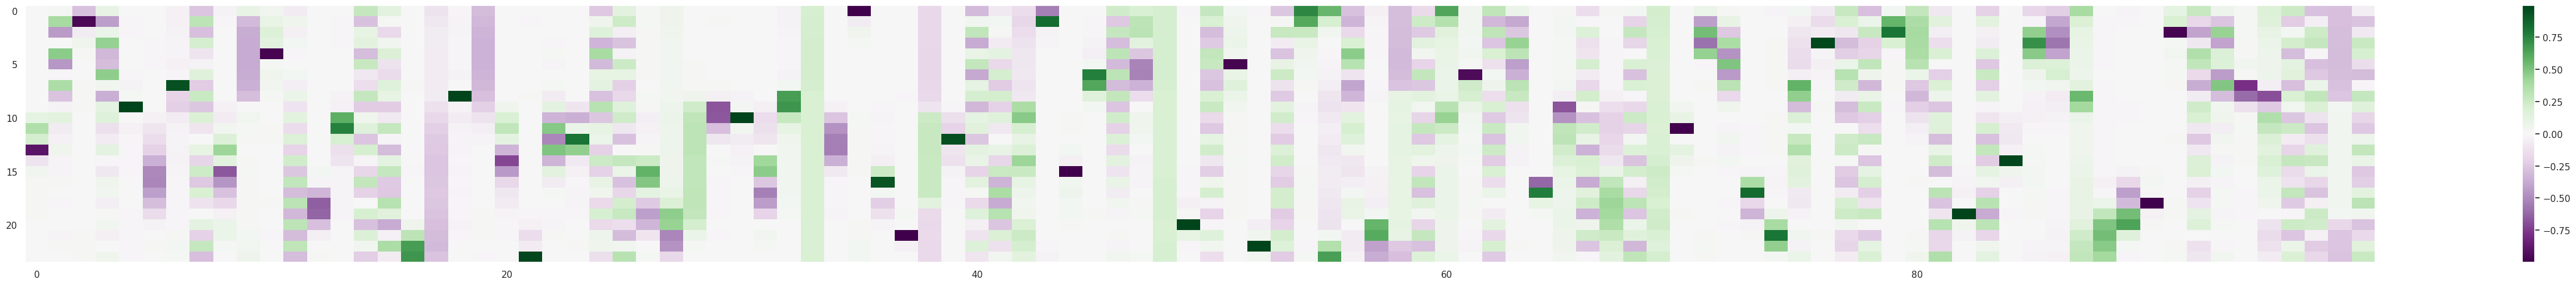

In [108]:
fig, ax = plt.subplots(figsize=(50,5))
fig.tight_layout()
im = ax.imshow(model.decoder.get_SigmaMapper().detach().numpy(), aspect='auto', cmap='PRGn', interpolation='none')
ax.grid(False)
fig.colorbar(im, ax=ax)
plt.show()

### Validation Set

In [109]:
x_val = torch.tensor(X_val).float()
x_val_conditions = conditions_val.copy()
x_rec, z_rec = model.reconstruct(x_val, torch.tensor(conditioner.transform(x_val_conditions)).float())

In [110]:
x_rec_mu = x_rec["params"]["mu"].detach().squeeze(0)
x_rec_sigma = model.decoder.get_marginal_sigmas(x_rec["params"]).detach().squeeze(0)

x_val_Sigma = model.decoder.create_covariance_matrix(x_rec["params"]).squeeze(0).detach()
x_val_Corr = x_val_Sigma / (x_rec_sigma[...,None]*x_rec_sigma[:,None,:])

x_val_denorm = utils.zero_preserved_log_denormalize(x_val.unsqueeze(0), nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()
x_rec_denorm = utils.zero_preserved_log_denormalize(x_rec_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()
x_rec_denorm_sigma_low = utils.zero_preserved_log_denormalize(x_rec_mu - 2*x_rec_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()
x_rec_denorm_sigma_high = utils.zero_preserved_log_denormalize(x_rec_mu + 2*x_rec_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()

Reconstruction Log-Likelihood: -5.3245
KL Divergence: 2.3140
**************************************************
Top-5 Mimimum RLL: [-312.8801  -228.92407 -196.15329 -181.52486 -125.66331] (Data index: [204559  60188  80031 148807  18949])
Top-5 Maximum KL: [23.899933 23.91377  24.06294  28.824276 29.34035 ] (Data index: [ 34007  27605   5966  92639 100247])


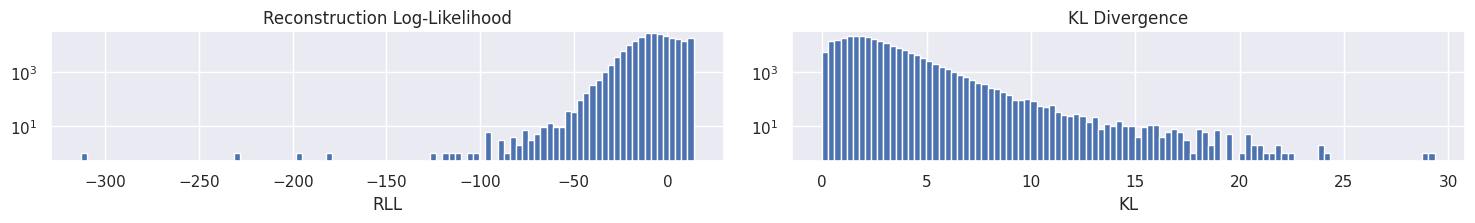

In [111]:
rll_val = model.reconstruction_loglikelihood(x_val, x_rec["params"]).detach().numpy()
kl_val = model.kl_divergence(z_rec["params"], prior_params=model.prior_params).detach().numpy()

print(f"Reconstruction Log-Likelihood: {rll_val.mean():.4f}")
print(f"KL Divergence: {kl_val.mean():.4f}")
print("*"*50)
print(f"Top-5 Mimimum RLL: {np.sort(rll_val)[:5]} (Data index: {np.argsort(rll_val)[:5]})")
print(f"Top-5 Maximum KL: {np.sort(kl_val)[-5:]} (Data index: {np.argsort(kl_val)[-5:]})")
fig, ax = plt.subplots(1,2, figsize=(15,2))
fig.tight_layout()
h_rll = ax[0].hist(rll_val, bins=100, log=True)
ax[0].set_title("Reconstruction Log-Likelihood")
ax[0].set_xlabel("RLL")
h_kl = ax[1].hist(kl_val, bins=100, log=True)
ax[1].set_title("KL Divergence")
ax[1].set_xlabel("KL")
ax[0].set_ylim(0.5, max(h_rll[0].max(), h_kl[0].max())*1.1)
ax[1].set_ylim(0.5, max(h_rll[0].max(), h_kl[0].max())*1.1)
plt.show()

Top-5 Mimimum Log10-Det: [-31.22471 -31.22471 -31.22471 -31.22471 -31.22471] (Data index: [31554, 76668, 131494, 113135, 190417])
Top-5 Maximum Log10-Det: [15.573103 16.151146 16.171167 16.17928  16.248856] (Data index: [201737, 141362, 28953, 158401, 155741])
Top-5 Minimum Total Variance: [1.200001 1.200001 1.200001 1.200001 1.200001] (Data index: [190417, 148681, 123545, 219005, 190764])
Top-5 Maximum Total Variance: [116.528404 120.69983  122.883804 123.24275  123.28404 ] (Data index: [201737, 28953, 141362, 158401, 155741])


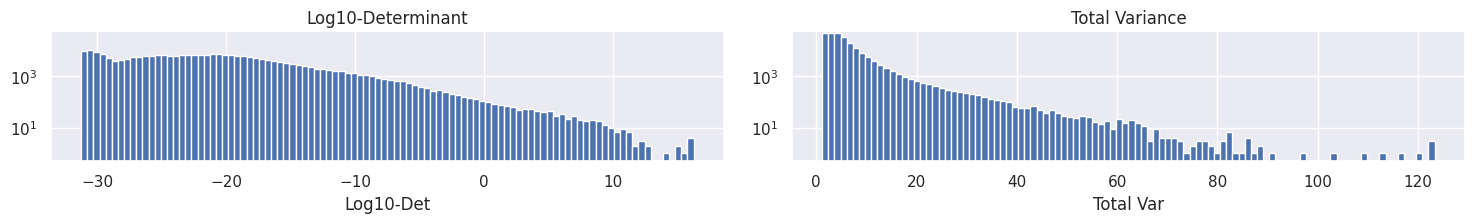

In [112]:
x_val_log10det = x_val_Sigma.logdet() * np.log10(np.e)
x_val_total_var = torch.diagonal(x_val_Sigma, dim1=-1, dim2=-2).sum(-1)

print(f"Top-5 Mimimum Log10-Det: {np.sort(x_val_log10det)[:5]} (Data index: {np.argsort(x_val_log10det)[:5].tolist()})")
print(f"Top-5 Maximum Log10-Det: {np.sort(x_val_log10det)[-5:]} (Data index: {np.argsort(x_val_log10det)[-5:].tolist()})")
print(f"Top-5 Minimum Total Variance: {np.sort(x_val_total_var)[:5]} (Data index: {np.argsort(x_val_total_var)[:5].tolist()})")
print(f"Top-5 Maximum Total Variance: {np.sort(x_val_total_var)[-5:]} (Data index: {np.argsort(x_val_total_var)[-5:].tolist()})")

fig, ax = plt.subplots(1,2, figsize=(15,2))
fig.tight_layout()
h_logdet = ax[0].hist(x_val_log10det, bins=100, log=True)
ax[0].set_title("Log10-Determinant")
ax[0].set_xlabel("Log10-Det")
h_corr = ax[1].hist(x_val_total_var, bins=100, log=True)
ax[1].set_title("Total Variance")
ax[1].set_xlabel("Total Var")
ax[0].set_ylim(0.5, max(h_logdet[0].max(), h_corr[0].max())*1.1)
ax[1].set_ylim(0.5, max(h_logdet[0].max(), h_corr[0].max())*1.1)
plt.show()


#### Inspect a specific validation data point

In [117]:
val_data_idx = 89890

print(f"User ID: {user_ids_val[val_data_idx]}")
print("*"*25)
print("{:<20}{:>5}".format("Condition", "Value"))
print("="*25)
for k, v in x_val_conditions.items():
    print(f"{k:<20}" + " ".join([f"{x:.2f}" for x in v[val_data_idx]]))

User ID: 3600
*************************
Condition           Value
months              2.00
weekdays            3.00
users               0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 331.05


In [118]:
z_rec["params"]["mu"][val_data_idx], z_rec["params"]["sigma"][val_data_idx]

(tensor([ 5.2294e-03,  1.2210e-02,  4.4490e-03,  1.6109e-03,  1.2472e-03,
          1.3241e-02, -3.1881e-03, -1.0000e-02, -1.9050e-02,  3.8510e-03,
          9.8614e-03, -8.8973e-01, -2.5935e-04,  2.7061e-03,  4.6449e-01,
          6.4024e-03,  6.4660e-04, -5.4680e-01, -3.6057e-03,  2.6901e+00,
          1.4715e-03, -1.5784e-02, -1.3073e-02, -1.0586e-02]),
 tensor([0.9961, 0.9984, 0.9997, 1.0003, 0.9994, 0.9921, 0.9989, 0.9966, 0.9877,
         1.0013, 1.0004, 0.3642, 0.9974, 1.0010, 0.1951, 0.9947, 1.0010, 0.1706,
         0.9991, 0.2017, 0.9988, 0.9920, 0.9998, 0.9940]))

In [119]:
print(f"Reconstruction Log-Likelihood: {rll_val[val_data_idx]}")
print("*"*100)
print(f"KL Divergence: {kl_val[val_data_idx]}")
print("*"*100)
print(f"Log10-Determinant: {x_val_log10det[val_data_idx]}")
print("*"*100)
print(f"Eigenvalues: {torch.linalg.eigvalsh(x_val_Sigma[val_data_idx])}")
print("*"*100)
print(f"Total Variance: {x_val_total_var[val_data_idx]}")
print("*"*100)
print(f"Marginal Variances: {x_val_Sigma[val_data_idx].diag().detach()}")
print("*"*100)
print(f"sigma values: {x_rec['params']['sigma'][0,val_data_idx]}")

Reconstruction Log-Likelihood: 1.3926773071289062
****************************************************************************************************
KL Divergence: 8.406277656555176
****************************************************************************************************
Log10-Determinant: -24.313291549682617
****************************************************************************************************
Eigenvalues: tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0502, 0.0506, 0.0512, 0.0585, 0.0730,
        0.1696, 0.2824, 0.8088, 1.1131, 1.1237, 1.4825])
****************************************************************************************************
Total Variance: 5.913549900054932
****************************************************************************************************
Marginal Variances: tensor([0.0504, 0.0507, 0.0505, 0.0503, 0.0503, 0.0503, 0.0513, 0.0502, 1.0909,
        0

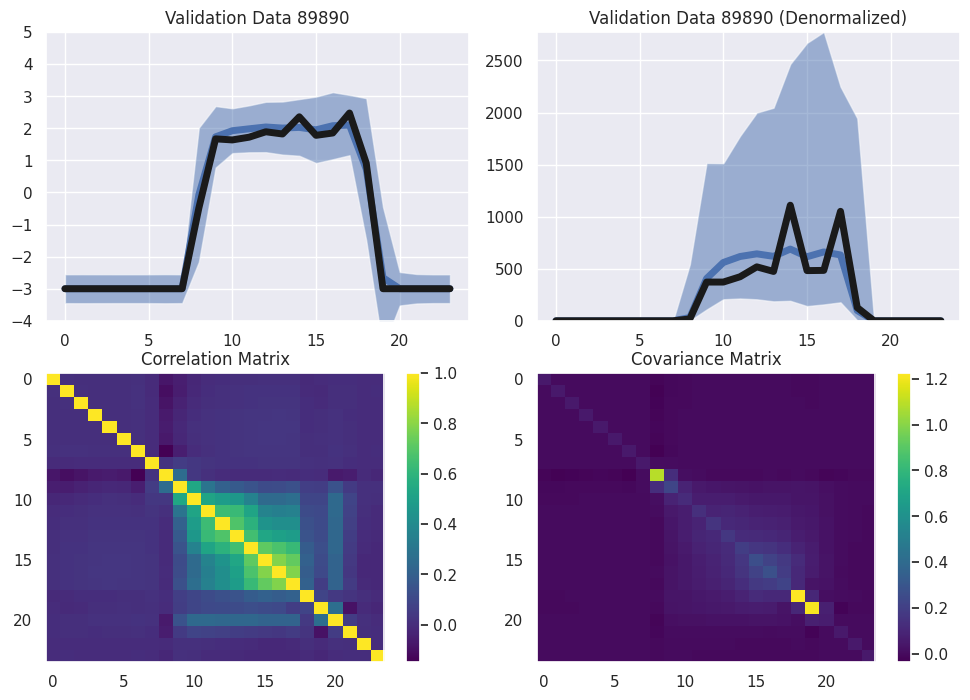

In [120]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
fig.tight_layout()
ax[0,0].plot(x_rec_mu[val_data_idx].detach().numpy(), lw=5)
ax[0,0].fill_between(np.arange(x_rec_mu.shape[1]), (x_rec_mu-2*x_rec_sigma)[val_data_idx], (x_rec_mu+2*x_rec_sigma)[val_data_idx], alpha=0.5)
ax[0,0].plot(x_val[val_data_idx].numpy(), lw=5, color='k')
ax[0,0].set_title(f"Validation Data {val_data_idx}")
ax[0,0].set_ylim(-4, 5)

ax[0,1].plot(x_rec_denorm[val_data_idx].T, lw=5)
ax[0,1].fill_between(np.arange(x_rec_denorm.shape[1]), x_rec_denorm_sigma_low[val_data_idx], x_rec_denorm_sigma_high[val_data_idx], alpha=0.5)
ax[0,1].plot(x_val_denorm[val_data_idx].T, lw=5, color='k')
ax[0,1].set_title(f"Validation Data {val_data_idx} (Denormalized)")
ax[0,1].set_ylim(0, max(x_rec_denorm_sigma_high[val_data_idx].max(),500))

im = ax[1,0].imshow(x_val_Corr[val_data_idx], aspect='auto', cmap='viridis', interpolation='nearest')
ax[1,0].set_title(f"Correlation Matrix")
ax[1,0].grid(False)
plt.colorbar(im)

im = ax[1,1].imshow(x_val_Sigma[val_data_idx], aspect='auto', cmap='viridis', interpolation='none')
ax[1,1].set_title(f"Covariance Matrix")
ax[1,1].grid(False)
plt.colorbar(im)
plt.show()

### Validation subset and reconstruction samples

In [124]:
num_subsamples, num_rec_samples = 5, 2
random_idx = np.random.choice(len(X_val), num_subsamples, replace=False)

In [127]:
samples = model.decoder.sample({k: v[0,random_idx] for k, v in x_rec["params"].items()},num_samples=num_rec_samples).detach()
samples_denorm = utils.zero_preserved_log_denormalize(samples, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)

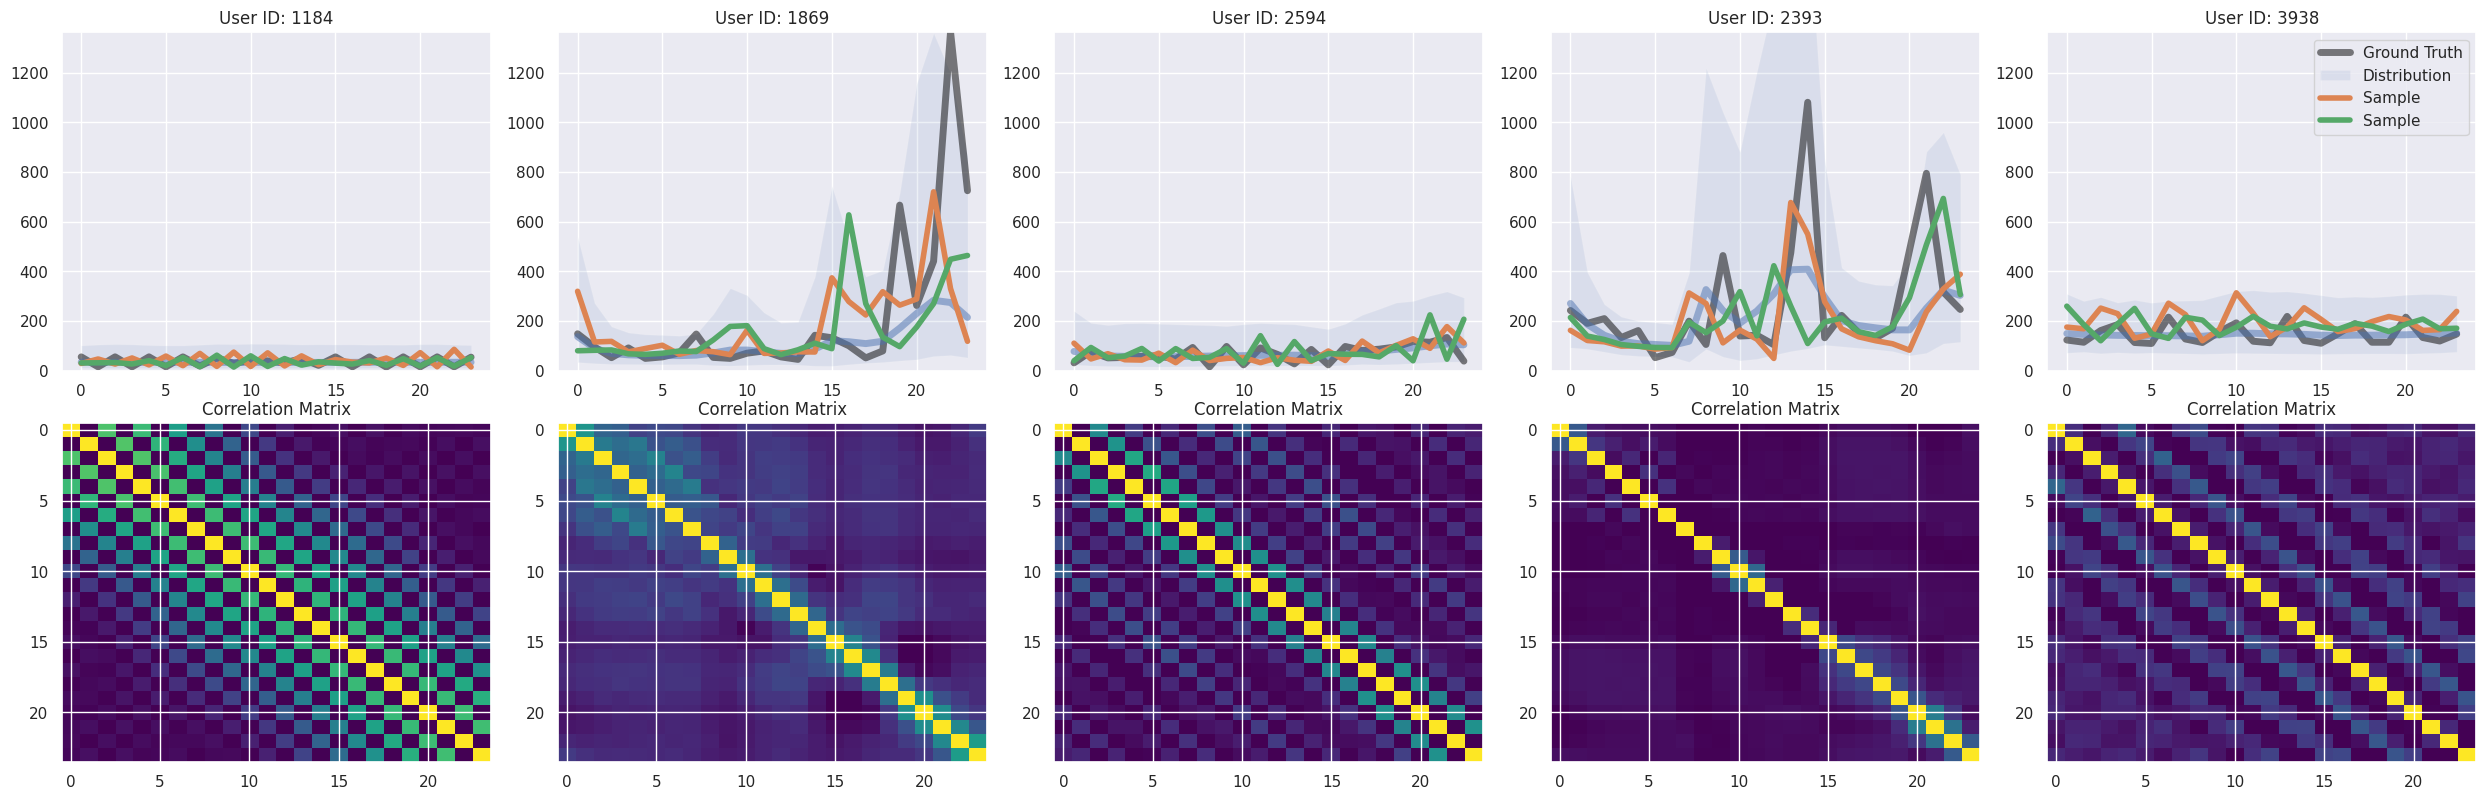

In [128]:
fig, ax = plt.subplots(2, 5, figsize=(25, 8))
fig.tight_layout()
for i in range(5):
    ax[0,i].plot(x_val_denorm[random_idx[i]].T, lw=5, alpha=0.5, color='black', label='Ground Truth')
    ax[0,i].plot(x_rec_denorm[random_idx[i]].T, lw=5, alpha=0.5)
    ax[0,i].fill_between(np.arange(x_val_denorm.shape[1]), x_rec_denorm_sigma_low[random_idx[i]].T, x_rec_denorm_sigma_high[random_idx[i]].T, alpha=0.1, label="Distribution")
    ax[0,i].plot(samples_denorm[:,i,:].squeeze().T, lw=4, label='Sample')
    ax[0,i].set_ylim([0, np.max(x_val_denorm[random_idx]).item()])
    ax[0,i].set_title(f"User ID: {user_ids_val[random_idx[i]]}")

    im = ax[1,i].imshow(x_val_Corr[random_idx[i]], aspect='auto', cmap='viridis', interpolation='none', vmin=0, vmax=1)
    ax[1,i].set_title(f"Correlation Matrix")
ax[0,-1].legend()
plt.show()

### Random sample

In [ ]:
random_condition_set, random_conditions = conditioner.get_random_conditions(1)
random_user_idx = np.random.choice(user_gamma.shape[0])
random_conditions["users"] = user_gamma[[random_user_idx]]
random_condition_set =  conditioner.transform(random_conditions)

print(f"User ID: {random_user_idx}")
print(f"*"*25)
print("{:<20}{:>5}".format("Condition", "Value"))
print("="*25)
for k, v in random_conditions.items():
    print(f"{k:<20}" + " ".join([f"{x:.2f}" for x in v[0]]))

User ID: 283
*************************
Condition           Value
months              7.00
weekdays            5.00
users               8.89 0.05 0.05 6.66 0.05 0.05 10.72 18.08 0.05 0.05 0.05 85.24 0.05 0.05 0.05 110.01 0.05 0.05 0.05 76.76


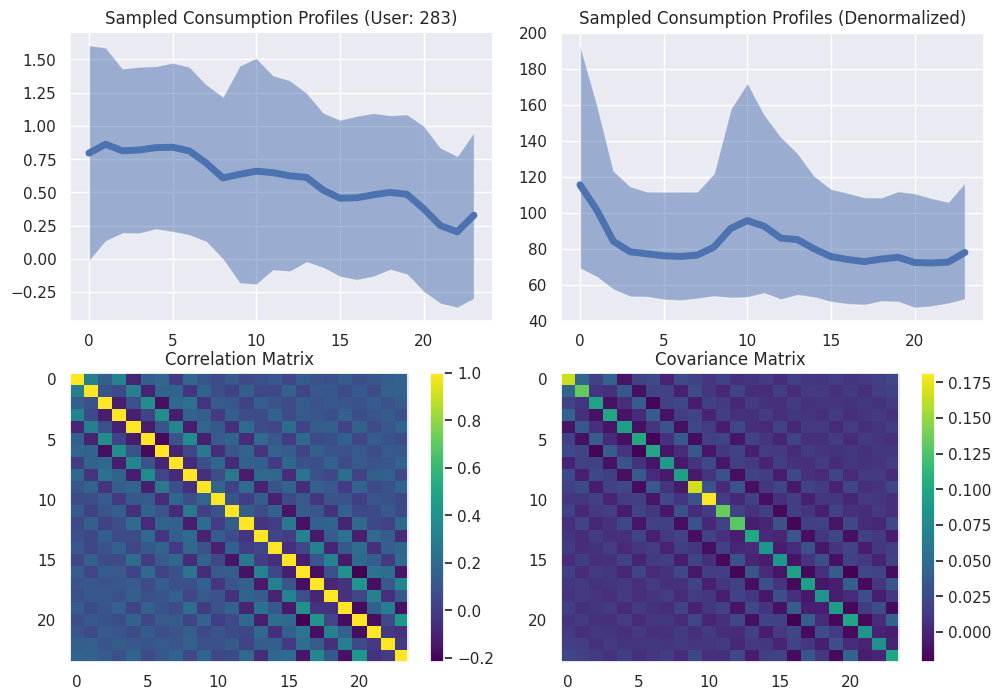

In [ ]:
x_sample = model.sample(condition=torch.tensor(random_condition_set).float(), num_samples_prior=1, num_samples_likelihood=1)
x_mu = x_sample["params"]["mu"].detach()
x_sigma = model.decoder.get_marginal_sigmas(x_sample["params"]).detach()
x_mu_denorm = utils.zero_preserved_log_denormalize(x_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_sigma_upper_denorm = utils.zero_preserved_log_denormalize(x_mu+x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_sigma_lower_denorm = utils.zero_preserved_log_denormalize(x_mu-x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_Sigma = model.decoder.create_covariance_matrix(x_sample["params"]).detach()
x_Corr = x_Sigma/ (x_sigma[...,None]*x_sigma[:,None,:])

fig, ax = plt.subplots(2, 2, figsize=(10, 7))
fig.tight_layout()
ax[0,0].plot(x_mu.T, lw=5)
ax[0,0].fill_between(np.arange(x_mu.shape[1]), (x_mu-2*x_sigma)[0], (x_mu+2*x_sigma)[0], alpha=0.5)
ax[0,0].set_title(f"Sampled Consumption Profiles (User: {random_user_idx})")
ax[0,1].plot(x_mu_denorm.T, lw=5)
ax[0,1].fill_between(np.arange(x_mu_denorm.shape[1]), x_sigma_lower_denorm[0], x_sigma_upper_denorm[0], alpha=0.5)
ax[0,1].set_title("Sampled Consumption Profiles (Denormalized)")
im = ax[1,0].imshow(x_Corr[0], aspect='auto', cmap='viridis', interpolation='nearest')
ax[1,0].set_title(f"Correlation Matrix")
ax[1,0].grid(False)
plt.colorbar(im)
im = ax[1,1].imshow(x_Sigma[0], aspect='auto', cmap='viridis', interpolation='none')
ax[1,1].set_title(f"Covariance Matrix")
ax[1,1].grid(False)
plt.colorbar(im)
plt.show()

## Inspection for a specific user

### Reconstruction samples

In [ ]:
user_id_selected = 0
random_idx = np.random.choice(np.where(user_ids_val == user_id_selected)[0], num_subsamples, replace=False)

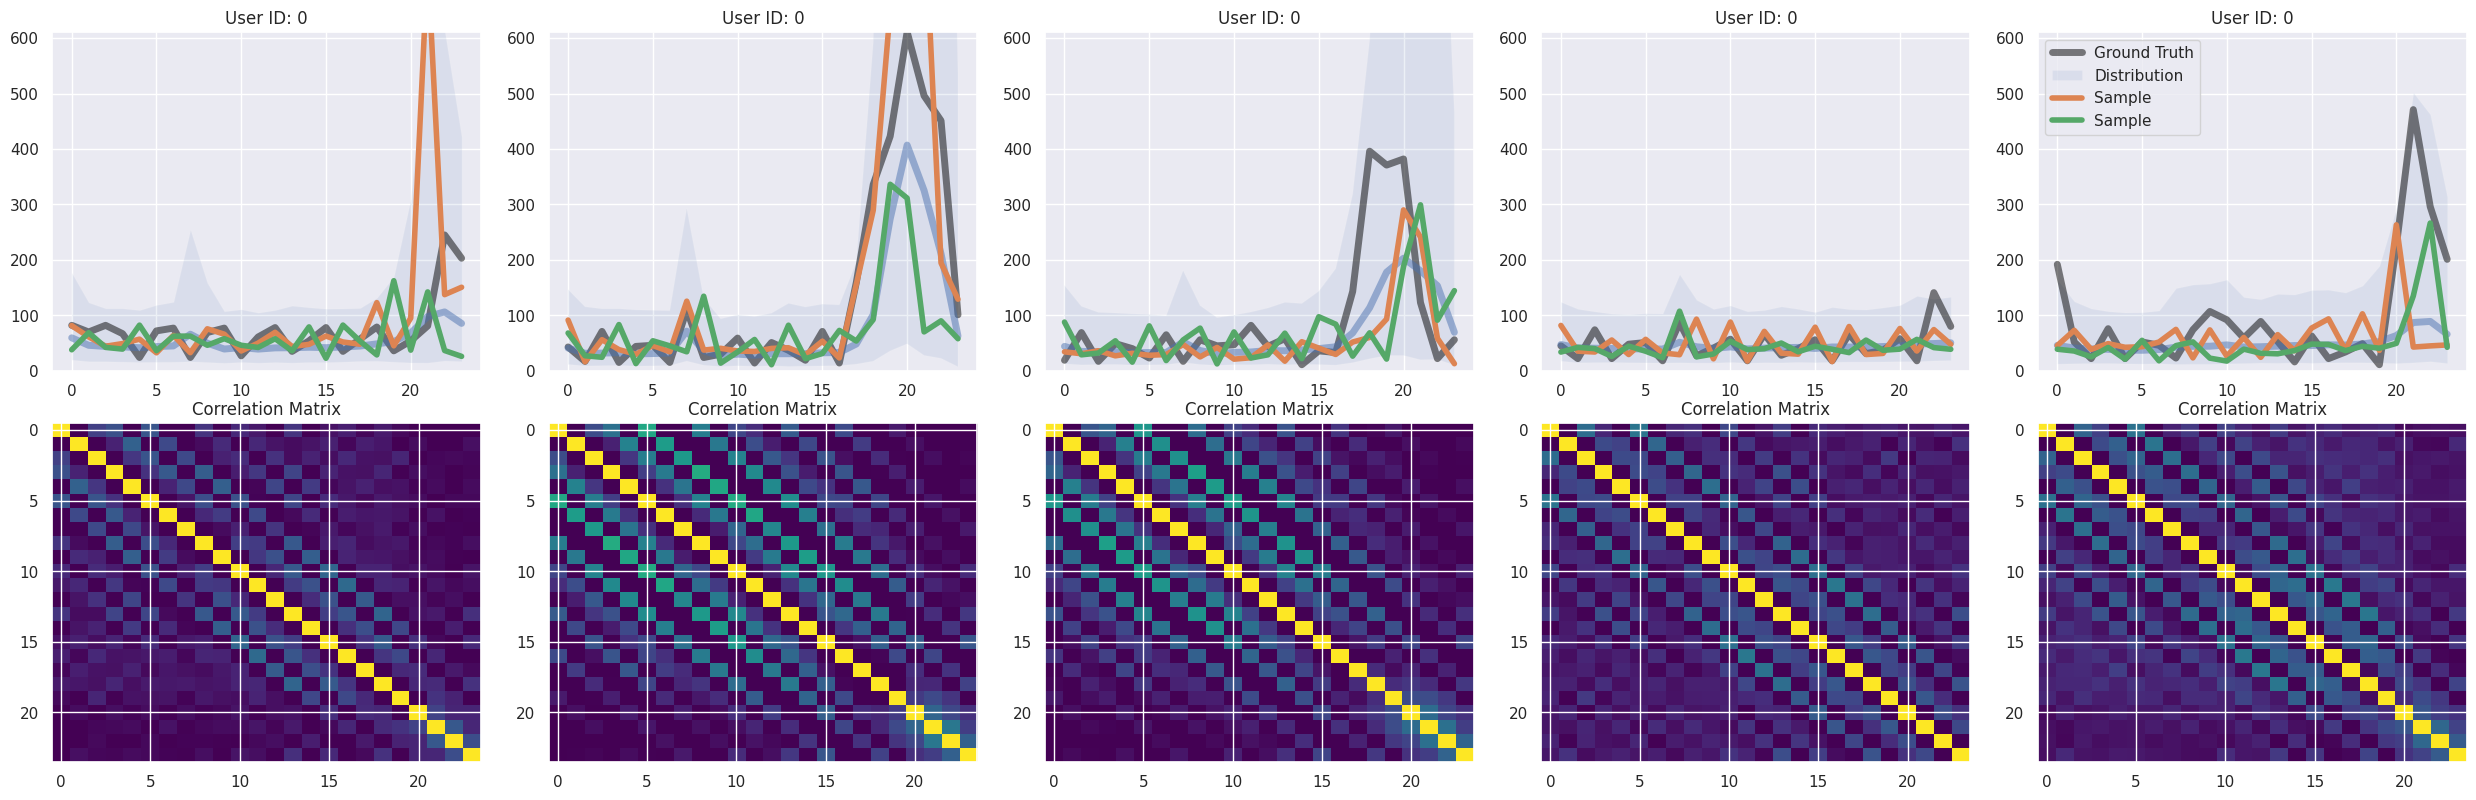

In [ ]:
samples = model.decoder.sample({k: v[0,random_idx] for k, v in x_rec["params"].items()},num_samples=num_rec_samples).detach()
samples_denorm = utils.zero_preserved_log_denormalize(samples, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)

fig, ax = plt.subplots(2, 5, figsize=(25, 8))
fig.tight_layout()
for i in range(5):
    ax[0,i].plot(x_val_denorm[random_idx[i]].T, lw=5, alpha=0.5, color='black', label='Ground Truth')
    ax[0,i].plot(x_rec_denorm[random_idx[i]].T, lw=5, alpha=0.5)
    ax[0,i].fill_between(np.arange(x_val_denorm.shape[1]), x_rec_denorm_sigma_low[random_idx[i]].T, x_rec_denorm_sigma_high[random_idx[i]].T, alpha=0.1, label="Distribution")
    ax[0,i].plot(samples_denorm[:,i,:].squeeze().T, lw=4, label='Sample')
    ax[0,i].set_ylim([0, np.max(x_val_denorm[random_idx]).item()])
    ax[0,i].set_title(f"User ID: {user_ids_val[random_idx[i]]}")

    im = ax[1,i].imshow(x_val_Corr[random_idx[i]], aspect='auto', cmap='viridis', interpolation='none', vmin=0, vmax=1)
    ax[1,i].set_title(f"Correlation Matrix")
ax[0,-1].legend()
plt.show()

### Random sample

In [ ]:
random_condition_set, random_conditions = conditioner.get_random_conditions(1)
random_conditions["users"] = user_gamma[[user_id_selected]]
random_condition_set =  conditioner.transform(random_conditions)

print(f"User ID: {random_user_idx}")
print(f"*"*25)
print("{:<20}{:>5}".format("Condition", "Value"))
print("="*25)
for k, v in random_conditions.items():
    print(f"{k:<20}" + " ".join([f"{x:.2f}" for x in v[0]]))

NameError: name 'user_id_selected' is not defined

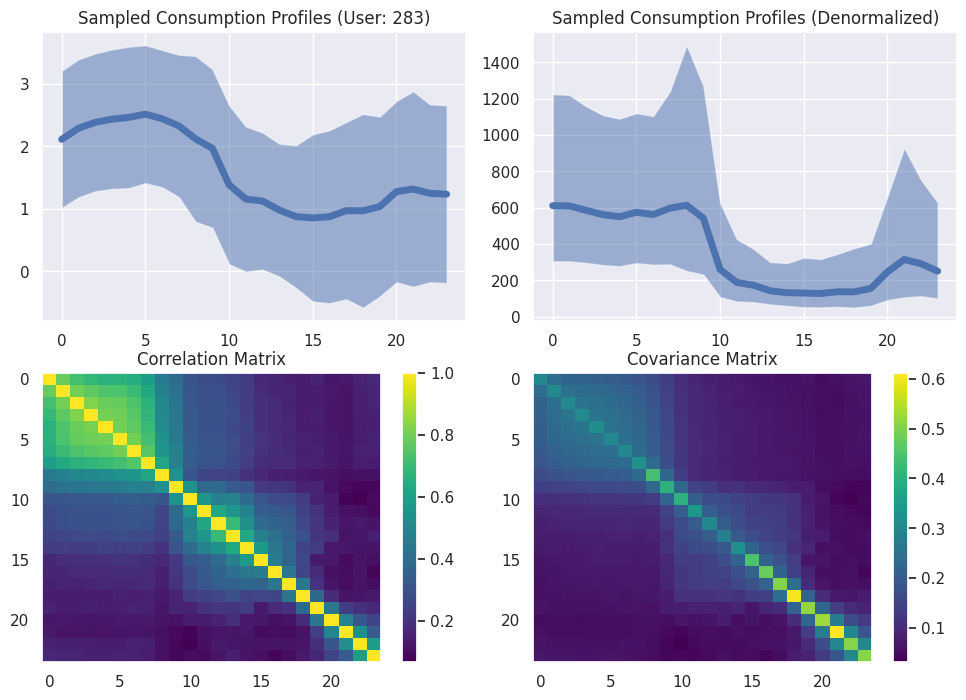

In [ ]:
x_sample = model.sample(condition=torch.tensor(random_condition_set).float(), num_samples_prior=1, num_samples_likelihood=1)
x_mu = x_sample["params"]["mu"].detach()
x_sigma = model.decoder.get_marginal_sigmas(x_sample["params"]).detach()
x_mu_denorm = utils.zero_preserved_log_denormalize(x_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_sigma_upper_denorm = utils.zero_preserved_log_denormalize(x_mu+x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_sigma_lower_denorm = utils.zero_preserved_log_denormalize(x_mu-x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_Sigma = model.decoder.create_covariance_matrix(x_sample["params"]).detach()
x_Corr = x_Sigma/ (x_sigma[...,None]*x_sigma[:,None,:])

fig, ax = plt.subplots(2, 2, figsize=(10, 7))
fig.tight_layout()
ax[0,0].plot(x_mu.T, lw=5)
ax[0,0].fill_between(np.arange(x_mu.shape[1]), (x_mu-2*x_sigma)[0], (x_mu+2*x_sigma)[0], alpha=0.5)
ax[0,0].set_title(f"Sampled Consumption Profiles (User: {random_user_idx})")
ax[0,1].plot(x_mu_denorm.T, lw=5)
ax[0,1].fill_between(np.arange(x_mu_denorm.shape[1]), x_sigma_lower_denorm[0], x_sigma_upper_denorm[0], alpha=0.5)
ax[0,1].set_title("Sampled Consumption Profiles (Denormalized)")
im = ax[1,0].imshow(x_Corr[0], aspect='auto', cmap='viridis', interpolation='nearest')
ax[1,0].set_title(f"Correlation Matrix")
ax[1,0].grid(False)
plt.colorbar(im)
im = ax[1,1].imshow(x_Sigma[0], aspect='auto', cmap='viridis', interpolation='none')
ax[1,1].set_title(f"Covariance Matrix")
ax[1,1].grid(False)
plt.colorbar(im)
plt.show()

## Backcasting

In [ ]:
test_data = utils.zero_preserved_log_normalize(X_gt_list[0]*1.0, nonzero_mean, nonzero_std, log_output=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)

In [ ]:
params, samples = model.sample(condition=torch.tensor(conditioner.transform({k: v[0] for k,v in X_gt_condition_list.items()})).float())

In [ ]:
model.loglikelihood(torch.tensor(test_data).float(), torch.tensor(conditioner.transform({k: v[0] for k,v in X_gt_condition_list.items()})).float(), num_mc_samples=100).detach().numpy()

array([-2.1499026, -4.880484 ], dtype=float32)

In [ ]:
backcasting_loglikelihoods = []
for user_id in range(num_users):
    test_data = utils.zero_preserved_log_normalize(X_gt_list[user_id]*1.0, nonzero_mean, nonzero_std, log_output=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
    if test_data.shape[0] == 0: loglikelihood = np.array([])
    else:
        loglikelihood = model.loglikelihood(torch.tensor(test_data).float(), torch.tensor(conditioner.transform({k: v[user_id] for k,v in X_gt_condition_list.items()})).float(), num_mc_samples=100).detach().numpy()
    backcasting_loglikelihoods.append(loglikelihood)
    print(f"User ID: {user_id}, Log-Likelihood: {loglikelihood.sum()}")

User ID: 0, Log-Likelihood: -7.689332962036133
User ID: 1, Log-Likelihood: 0.0


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
X_gt_condition_list["users"][3]

array([[5.00000002e-02, 5.00000017e-02, 5.00000004e-02, 2.34494137e+01,
        1.11443120e+02, 5.00000001e-02, 5.00000000e-02, 5.00000011e-02,
        5.00000005e-02, 1.31414039e+02, 5.00000000e-02, 2.33566556e+00,
        5.00000000e-02, 7.46077621e+01, 5.00000000e-02, 5.00000002e-02,
        5.00000000e-02, 5.00000000e-02, 5.00000006e-02, 5.00000004e-02],
       [5.00000002e-02, 5.00000017e-02, 5.00000004e-02, 2.34494137e+01,
        1.11443120e+02, 5.00000001e-02, 5.00000000e-02, 5.00000011e-02,
        5.00000005e-02, 1.31414039e+02, 5.00000000e-02, 2.33566556e+00,
        5.00000000e-02, 7.46077621e+01, 5.00000000e-02, 5.00000002e-02,
        5.00000000e-02, 5.00000000e-02, 5.00000006e-02, 5.00000004e-02],
       [5.00000002e-02, 5.00000017e-02, 5.00000004e-02, 2.34494137e+01,
        1.11443120e+02, 5.00000001e-02, 5.00000000e-02, 5.00000011e-02,
        5.00000005e-02, 1.31414039e+02, 5.00000000e-02, 2.33566556e+00,
        5.00000000e-02, 7.46077621e+01, 5.00000000e-02, 5.0000

In [ ]:
{k: v[user_id] for k,v in X_gt_condition_list.items()}

{'months': array([[6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6]]),
 'weekdays': array([[1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [0],
        [1],
        [2],
        [3],
        [4]]),
 'users': array([], dtype=float64)}